<a href="https://colab.research.google.com/github/ivoytov/manhattan/blob/master/loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import numpy as np
import pandas as pd
import datetime

### Data Sources ###
Loan data is from Bloomberg BVAL, based on end of day price valuation. Loan list is compiled by screening for:

1.   Active Loans
2.   First Lien Rank
3.   Incorporated in the U.S.
4.   Denominated in USD
5.   \>= $1B outstanding
6.   Non-Investment Grade Rating from either S&P *or* Moody's

The screen is run as of the last day of every quarter (3/31, 6/30, 9/30, and 12/31). Loans that mature or expire during a quarter are included in that quarterly period, but are removed from the screen for the following quarter.

### Data Format

* `loan_data` - Loan IDs are arranged as separate columns, with the first column containing the date index. Price is listed as values in XX.XX format (% of par). If price is unavailable, then #N/A is listed. Trading days only. There are two files, one for loans from 12-31-2018 to 10-15-2020 period, and one for the 12-31-2015 to 12-31-2018 period.

* `loan_desc` - Loan IDs are arranged in the first column, with subsequent columns containing metadata on the loan.

* `periods` - Quarters are listed as separate columns. Loan IDs from the above-mentioned screen are listed under the column header with the `as of` date.

In [214]:
# read in historical prices
prices_2019_2020 = pd.read_csv('/content/drive/MyDrive/loans/loan_data_2019-2020.csv', parse_dates=['Dates'], index_col='Dates')
prices_2016_2018 = pd.read_csv('/content/drive/MyDrive/loans/price_data_2016-2018.csv', parse_dates=['Dates'], index_col='Dates')

prices = pd.concat([prices_2016_2018, prices_2019_2020], join="outer", verify_integrity=True)
print("(# dates, # tickers)",prices_2016_2018.shape, prices_2019_2020.shape, prices.shape)
prices = prices.fillna(method="pad")
# take a geometric moving average with 5 day lookback (partially to clean up dataset and avoid spurious trading)

# not used yet
#desc = pd.read_csv('/content/drive/MyDrive/loans/loan_desc.csv', parse_dates=['FUNDING_DATE', 'MATURITY', ], index_col='ID')

(# dates, # tickers) (749, 946) (463, 530) (1212, 1202)


Below is a price graph of the trading history of every loan that breached price of ~85 for the first time, for a 10 trading period before the breach and 10 day period after the breach. The mean is shown in thick blue. There is a slight upward momentum observed in loans that breach 85 for the following 5-7 trading days.

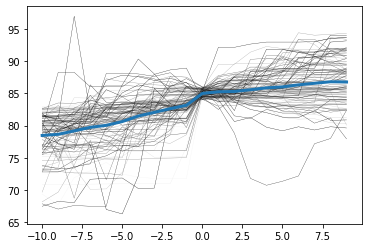

In [215]:
numDays = 10
out = pd.DataFrame()
for ticker in prices:
  close = prices[ticker]
  try:
    t0 = close[(close.diff(periods=numDays) > 3) & (close > 84) & (close < 86)].index[0]
  except:
    # loan never met criteria, skip
    continue
  yx = close.iloc[close.index.get_loc(t0) - numDays:close.index.get_loc(t0) + numDays]
  yx.index = range(-numDays,len(yx.index)-numDays)
  out = pd.concat([out, yx], axis=1)
  
out.plot(kind="line", legend=False, colormap="binary", linewidth=.3)  
out.T.mean().plot(linewidth=3)

Same analysis, but for loans that decline in price below 91. There is a stronger negative momentum effect, most likely due to a few cases that declined by 20% or more. The trend reverts sligtly after 5 days but is still meaningful.

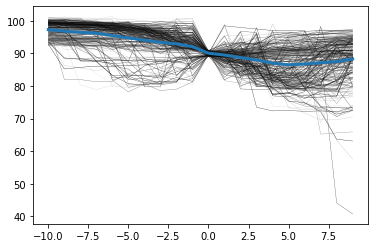

In [216]:
numDays = 10
out = pd.DataFrame()
for ticker in prices:
  close = prices[ticker]
  try:
    t0 = close[(close.diff(periods=numDays) < -3) & (close > 89) & (close < 91)].index[0]
  except:
    # loan never met criteria, skip
    continue
  yx = close.iloc[close.index.get_loc(t0) - numDays:close.index.get_loc(t0) + numDays]
  yx.index = range(-numDays,len(yx.index)-numDays)
  out = pd.concat([out, yx], axis=1)
  
out.plot(kind="line", legend=False, colormap="binary", linewidth=.3)  
out.T.mean().plot(linewidth=3)

The trading strategy is to buy every loan that has appreciated by at least 3% (`BIG_MOVE`) and traded into 83-87 price range (`BUY_PRICE_RANGE`) and to short every loan that traded into 88-92 price range while declining by the big move amount. To calculate the decline, we compare the price from 10 days ago (`LOOKBACK_DAYS`) to today, and put the trade on in the following trading session. To smooth out and reduce amount of spurious trading, we use a geometric moving average of the price to determine the signal but with only a 2 day span (given the very short term nature of this signal, a longer span period means we miss the period when the alpha is realized). We hold the position for a maximum of 10 days (`HOLD_DAYS`) - unless the position moves by 3% in either direction, when we stop loss or take profit early.

In [217]:
LOOKBACK_DAYS = 10
HOLD_DAYS = 10
BIG_MOVE = .03
BUY_PRICE_RANGE = [83, 87]
SELL_PRICE_RANGE = [88, 92]
prices_ma = prices.ewm(span=2).mean()
price_chg = prices_ma.pct_change(periods=LOOKBACK_DAYS)
buy = (price_chg.shift(1) > BIG_MOVE) & (prices > BUY_PRICE_RANGE[0]) & (prices < BUY_PRICE_RANGE[1])
sell = (price_chg.shift(1) < -BIG_MOVE) & (prices > SELL_PRICE_RANGE[0]) & (prices < SELL_PRICE_RANGE[1])
labels = buy*1.0 - sell*1.0

Demonstration of some sample `labels` output. `1` means we are long the loan in the quarter that start on the day shown on the left (index) column. So we are short the loan BL330764 starting 2020-04-01, and we are long the loan BL329204 starging 2020-04-03. `0` means we have no position in the loan, either because it didn't exist or because it didn't have a big move in the lookback period. To avoid lookback bias, the date shown below is one trading day after the loan met the buy or sell criteria.

In [218]:
labels.loc['2020-04-01':'2020-04-07', ['BL329204', 'BL330764']]

,BL329204,BL330764
Dates,,
2020-04-01,0.0,-1.0
2020-04-02,0.0,-1.0
2020-04-03,0.0,0.0
2020-04-06,1.0,0.0
2020-04-07,1.0,0.0


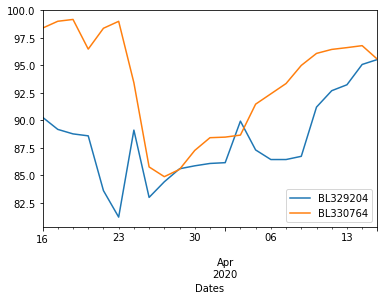

In [219]:
yx = prices_ma.loc['2020-03-15':'2020-04-15',['BL329204', 'BL330764']]
yx.plot(kind='line')

Functions to:
* Generate labels between {-1, 0, 1} that mean we are short, neutral, or long the loan ID for that entire period

* Generate bins between {0, 1} that mean that the trade was good (\>$0 PNL, or `1`) or bad (negative PNL, or `0`) based on the side we picked in `labels` and the actual price change in the following period. Ignores interest income.

In [220]:
# triple barrier method function
# close:  a pandas series of prices
# events: a pandas dataframe wiht columns
#   - t1:   the timestamp of vertical barrier. When np.nan, no vertical barrier
#.  - trgt: the unit width of the horizontal barriers
# ptSl: a list of two non negative floats
#   - ptSl[0] the factor that multiplies trgt to set the width of the upper barrier. if 0, no upper barrier
#   - ptSl[1] the factor tha multiplesi trgt ot set the width of the lower barrier. if 0, no lower barrier
# molecule a list with the subset of event indices that will be processed by single thread

def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0]>0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) #NaNs

    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index = events.index) #NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] #path prices
        df0 = (df0 / close[loc] -1) * events_.at[loc,'side'] # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min() # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min() # earliest profit taking
    return out

def getVertBarrier(gRaw, tEvents, numDays: int) -> pd.Series:
    t1 = gRaw.index.searchsorted(tEvents + pd.Timedelta(days = numDays))
    t1 = t1[t1 < gRaw.shape[0]]
    t1 = pd.Series(gRaw.index[t1], index=tEvents[:t1.shape[0]]) #NaNs at the end
    t1 = t1.rename('t1')
    return t1

def getBins(events: pd.DataFrame, close: pd.Series) -> pd.DataFrame:
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

# find the time of the first barrier touch
#  close: pandas series of prices
#  tEvents pandas timeindex of timestamps that will seed every ttriple barrier
#  ptSl a non negative flat that sets the width of th two barriers (symm)
# t1 pandas series with the timestamps of the vert barriers. pass false to disable
# trgt: pandas series of targets, expressed in terms of absolute returns
# minRet minimum target return required for running a triple barrier search
# numThreads  not used yet

# output:
# - t1: timestamp of when the first barrier is touched
# - trgt: the target that was used to generate the horizontal barrier

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents, dtype='datetime64')

    #3) form events object, apply stop loss on t1
    if side is None:
        side_ = pd.Series(1., index=trgt.index)
        ptSl_ = [ptSl, ptSl]
    else:
        side_ = side.loc[trgt.index]
        ptSl_ = ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_ }, axis = 1).dropna(subset=['trgt'])

    df0 = applyPtSlOnT1(close, events, ptSl_, events.index)
    events['t1'] = df0.dropna(how='all').apply(lambda x: x.min(),axis=1)
    if side is None:
        events = events.drop('side', axis = 1)
    events = events.dropna(subset=['t1'])
    return events

# daily vol, reindexed to close
def getDailyVol(close, span=14):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days = 1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0].values - 1 # daily returns
    df0 = df0.ewm(span=span).std().rename('trgt')
    return df0

def getBins(events, close):
    '''
    Compute event's outcome (including side info, if provided)
    events is a dataframe where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target return
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events) bin in (-1, 1) <- label by price action
    Case 2: ('side' in events) bin in (0,1) <- label by pnl (meta labeling)
    '''
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1']).drop_duplicates()
    px = close.reindex(px, method='bfill')

    #2) create out object
    out = pd.DataFrame(index = events_.index)
    out['ret'] = px.loc[events_['t1']].values / px.loc[events_.index] - 1 
    out['t1'] = events_['t1']
    if 'side' in events_:
        out['ret'] *= events_['side']     # meta-labeling

    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0    # meta-labeling
        out['side'] = events_['side']
    return out

The trading strategy is to observer trading prices of loans trading below 85 (`PRICE_RANGE`), when one of them gains 3 percent (`BIG_MOVE`) in any 5 day period (`LOOKBACK_DAYS`), then we buy the loan on the following days close. We hold the loan for 5 days (`HOLD_DAYS`) and sell. If the position moves in our favor or against us by 3%, then we stop loss or harvest early.

The `getBins` function returns a table of trade outcomes for each loan in {0,1} - 1 if trade made money, 0 if the trade lost money. 

In [221]:
out = pd.DataFrame()
for ticker in labels.columns:
  dates = labels[ticker][labels[ticker] != 0].index
  t1 = getVertBarrier(prices[ticker], dates, HOLD_DAYS)
  trgt = getDailyVol(prices[ticker])
  events = getEvents(prices[ticker], dates, ptSl=[.03,.03], trgt=trgt, minRet=0, numThreads=1, t1=t1, side=labels[ticker])
  bins = getBins(events, prices[ticker])
  bins['ticker'] = ticker   
  out = pd.concat([out, bins])

bins = out.set_index('ticker', append=True)
bins

,,ret,t1,bin,side
Dates,ticker,,,,
2016-01-19,BL101755,0.000697,2016-01-22,1.0,-1.0
2016-01-20,BL101755,0.000697,2016-01-22,1.0,-1.0
2016-01-21,BL101755,0.000697,2016-01-22,1.0,-1.0
2016-03-22,BL101755,0.012233,2016-03-23,1.0,1.0
2016-12-01,BL101755,-0.008415,2016-12-05,0.0,-1.0
...,...,...,...,...,...
2020-03-18,BL323453,0.009136,2020-03-19,1.0,-1.0
2020-03-19,BL323453,0.063875,2020-03-20,1.0,-1.0
2020-03-26,BL323453,-0.004819,2020-03-30,0.0,-1.0


Group the events by side and calculate how often the trade makes money. Both events triggered thousands of times so this is a robust sample - but do note that there is some overlap in the events. There were more long than short events. The long trades generated a median return of 32 bps in the reasonably short holding period, while the short trades lost 47 bps. This is before trading fees, which on a $1B+ loan can be estimated at ~30 bps each side (60bps round trip).

In [222]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

pd.pivot_table(bins, index=['side'], values='ret', aggfunc=[len, np.mean,  percentile(25), 
                                                            percentile(50), percentile(75), 
                                                            max, min, np.sum])

,len,mean,percentile_25,percentile_50,percentile_75,max,min,sum
,ret,ret,ret,ret,ret,ret,ret,ret
side,,,,,,,,
-1.0,1742.0,0.004727,-0.004224,-0.000000,0.006868,0.507671,-0.098058,8.234024
1.0,1156.0,0.003281,-0.002196,0.001447,0.004511,0.125006,-0.066322,3.792310


Plot the histogram of the returns from the long trades and then the short trades. We clip the histogram window at +/- 10% return to avoid showing the huge outliers.

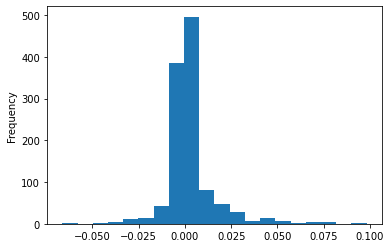

In [223]:
bins[(bins.side == 1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)

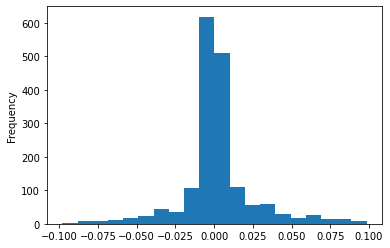

In [224]:
bins[(bins.side == -1) & (bins.ret <.1) & (bins.ret >-.1)].ret.plot.hist(bins=20)